In [11]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
import pints.toy as toy
import pints
import numpy as np
import logging
import math
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import sys
from numpy import inf
import copy 
import pickle
import time
import cma_arnaud
import igocma

model_dict = dict()

In [2]:
# ROSENBROCK Distribution # 
mod_dict = dict()

mod_dict['name'] = "ROSENBROCK"

log_pdf = pints.toy.RosenbrockLogPDF()
mod_dict['model'] = log_pdf
# Use suggested prior bounds
bounds = log_pdf.suggested_bounds()
# Create a uniform prior over both the parameters
log_prior = pints.UniformLogPrior(
    bounds[0], bounds[1])
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_pdf, log_prior)
mod_dict['score'] = log_posterior

# Dummy Entries should be removed at some point
mod_dict['times']  = []
mod_dict['real_parameters']  = [1,1]

mod_dict['graph_limit'] = [-0.1,1.1]
mod_dict['normalized_graph_limit'] = [-0.1,1.1]

mod_dict['boundaries'] = pints.RectangularBoundaries([-2, -1], [4, 12])

# Choose an initial position
mod_dict['x0'] = [0.5, 3]

model_dict['Rosenbrock'] = mod_dict

In [3]:
# LOGISTIC MODEL # 
log_dict = dict()

log_dict['name'] = "Logistic model"
log_dict['model'] = toy.LogisticModel()

log_dict['real_parameters'] = [0.5, 500]
log_dict['times']  = log_dict['model'].suggested_times()

log_dict['boundaries'] = pints.RectangularBoundaries([0, 200], [1, 1000])
log_dict['graph_limit'] = [0,6000]
log_dict['normalized_graph_limit'] = [0,20]

# Choose an initial position
log_dict['x0'] = [0.2, 420]

model_dict['Logistic'] = log_dict

In [12]:
# HES_1 #
H1_dict = dict()

H1_dict['name'] = "HES1 Michaelis-Menten"
H1_dict['model'] = toy.Hes1Model()

H1_dict['real_parameters'] = H1_dict['model'].suggested_parameters() #[2.4, 0.025, 0.11, 6.9]
H1_dict['times'] = H1_dict['model'].suggested_times()

H1_dict['boundaries'] = pints.RectangularBoundaries([-20, -2, -2, -200], [20, 2, 2, 200])
H1_dict['graph_limit'] = [15,60]
H1_dict['normalized_graph_limit'] = [0.5,20]

H1_dict['x0'] = [7, 0.35, 0.9, 20]

model_dict['HES Michaelis-Menten'] = H1_dict

In [5]:
# HH_IK #
HH_dict = dict()

HH_dict['name'] = "Hodgkin Huxley IK model"
HH_dict['model'] = toy.HodgkinHuxleyIKModel()

HH_dict['real_parameters'] = HH_dict['model'].suggested_parameters() # 0.01, 10, 10, 0.125, 80
HH_dict['times'] = HH_dict['model'].suggested_times()

HH_dict['boudaries'] = pints.RectangularBoundaries([-2, -200, -200, -2, -200], [2, 200, 200, 2, 200])
HH_dict['graph_limit'] = [0,5500]
HH_dict['normalized_graph_limit'] = [0,20]

HH_dict['x0'] = 0.001, 5, 20, 0.335, 37

model_dict['Hodgkin_Huxley'] = HH_dict

In [6]:
def get_percentile_graphs(perc_val, all_results_info, limit=None, filename=None, score_normalizer=1):
    axes = plt.gca()
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    for best_fxs, color, name in all_results_info:
        best_fxs = sorted(best_fxs, key= lambda x : x[-1])
        
        perc = best_fxs[int(perc_val * len(best_fxs))] / score_normalizer
        
        print("score", best_fxs[int(perc_val * len(best_fxs))][-1])
        print("normalized_score", best_fxs[int(perc_val * len(best_fxs))][-1] / score_normalizer)
        print()
        
        plt.plot(perc, color, label=name)
        if limit is not None:
            axes.set_ylim(limit)
    lgd = plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
    if filename:
        plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [7]:
def model_testbed(model,
                  real_parameters,
                  times,
                  optimizers_info,
                  iterations=250,
                  score=None,
                  tries=25,
                  timed=False,
                  maximization=False,
                  is_prob_model=False,
                  limit=None,
                  problem_name=None):
    
    if score is None:
        #Generate the values
        try:
            values, _ = model.simulateS1(real_parameters, times)
        except:
            values = model.simulate(real_parameters, times)

        # Add noise
        values += np.random.normal(0, 0.75, values.shape)
        # Create an object with links to the model and time series
        try:
            my_problem = pints.SingleOutputProblem(model, times, values)
        except:
            my_problem = pints.MultiOutputProblem(model, times, values)

        # Select a score function
        score = pints.MeanSquaredError(my_problem)
        score_normalizer = score(real_parameters)
    # We should apply the exp of the log pdf which is "model"
    else:
        score_normalizer = np.exp(model(real_parameters))
        
    all_results_info = list()
    
    for name, start_opt, color in optimizers_info:
        print("Starting", name, "for", tries, "tries with", iterations,"iterations each" )
        all_best_fxs = []
        all_best_xs = []
        fail_count = 0
        
        if timed:
            start = time.time()
            
        for j in range(tries):
            opt = copy.copy(start_opt)
            best_fxs = []
            best_xs = []
            try:
                for i in range(iterations):
                    xs = opt.ask()
                    # Save the values for the plot 
                    if (i) % 5 == 0:
                        best_xs.append(opt.xbest())
                    # Evaluate the scores
                    if maximization:
                        fxs = [ - score(x) for x in xs]
                    else:
                        fxs = [score(x) for x in xs]
                    opt.tell(fxs)
                    # Store the best score
                    if is_prob_model:
                        best_fxs.append(np.exp(model(opt.xbest())))
                    else:
                        best_fxs.append(opt.fbest())
                    best_xs.append(opt.xbest())
                all_best_fxs.append(best_fxs)
                all_best_xs.append(best_xs)
            except Exception as e:
                print('One run failed: ', e)
                print()
                fail_count += 1
                
        if timed:
            end = time.time()
            print("Done in", end - start, "seconds")        
        print("Failed", fail_count, "times")
        
        # Save the results for the specific model
        all_results_info.append((all_best_fxs, color, name))
        
        # Sort the fxs and xs according to the fxs
        zipped = list(map(lambda x, y:(x,y), all_best_fxs, all_best_xs))
        if is_prob_model:
            all_best_fxs = [[np.exp(model(x)) for x in z] for _, z in sorted(zipped, key=lambda x: x[0][-1], reverse=True)]
            all_best_xs = [z for _, z in sorted(zipped, key=lambda x: x[0][-1], reverse=True)]       

        else:
            all_best_fxs = [z for z, _ in sorted(zipped, key=lambda x: x[0][-1])]
            all_best_xs = [z for _, z in sorted(zipped, key=lambda x: x[0][-1])]       

        very_best_x = all_best_xs[0][-1]
        dist_from_true = normalized_distance(very_best_x, real_parameters, real_parameters)
        close_enough_to_best_count = 0
        for i in range(tries - fail_count):
            if normalized_distance(very_best_x, all_best_xs[i][-1], real_parameters) <= 2 * dist_from_true:
                close_enough_to_best_count +=1
        print("Ratio of points within distance d (d = distance between best_x and real_params) from the best x:",
              close_enough_to_best_count/(tries - fail_count))
        
        # Print the best fx of the 10th percentile run, the median run and the 90th percentile run
        print("10th Percent.   |   median    |    90th Percent. for ", name)
        l = len(all_best_fxs) - fail_count
        parity = 1 if l % 2 == 1 else 0
        ten_perc = all_best_fxs[min(9 * (l + parity) // 10, l-1)] / score_normalizer
        median  = all_best_fxs[(l + parity) // 2]  / score_normalizer
        ninetieth_perc = all_best_fxs[(l + parity) // 10]  / score_normalizer
        print( "{0:.5f}".format(ten_perc[-1]), " \t ", "{0:.5f}".format(median[-1]), " \t ", "{0:.5f}".format(ninetieth_perc[-1]))

        # Plot the evolution of the fx of the 10th percentile run, the median run and the 90th percentile run
        axes = plt.gca()
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.plot(ten_perc, '#4682B4', label='10th')
        plt.plot(median, '#40E0D0', label='median')
        plt.plot(ninetieth_perc, '#0000CD', label='90th')
        plt.legend(loc='upper right',  bbox_to_anchor=(1.25, 1))
        if limit is not None:
            axes.set_ylim(limit)
        plt.show()

    
    # Show how the score converges
    print("All scores")
    print("TENTH PERC")
    get_percentile_graphs(0.9, all_results_info, limit=limit, filename=problem_name + "_10.pdf",  score_normalizer=score_normalizer)
    
    print("MEDIAN")
    get_percentile_graphs(0.5, all_results_info, limit=limit, filename=problem_name + "_MED.pdf",  score_normalizer=score_normalizer)
    
    print("NINETENTH PERC")
    get_percentile_graphs(0.1, all_results_info, limit=limit, filename=problem_name + "_90.pdf",  score_normalizer=score_normalizer)
     
    return all_results_info

In [8]:
def save_all_percentile_graphs(all_results_info, graph_limit, filename, score_normalizer):
    print("TENTH PERC")
    get_percentile_graphs(0.9, all_results_info, limit=graph_limit, 
                          filename=filename + "_10.pdf", score_normalizer=score_normalizer)
    
    print("MEDIAN")
    get_percentile_graphs(0.5, all_results_info, limit=graph_limit, 
                          filename=filename + "_MED.pdf", score_normalizer=score_normalizer)
    
    print("NINETENTH PERC")
    get_percentile_graphs(0.1, all_results_info, limit=graph_limit, 
                          filename=filename + "_90.pdf", score_normalizer=score_normalizer)

In [9]:
def normalized_distance(param1, param2, true_param):
    norm1 = [param1[i] / np.absolute(true_param[i]) for i in range(len(true_param))]
    norm2 = [param2[i] / np.absolute(true_param[i]) for i in range(len(true_param))]
    norm_dist = np.sqrt(sum([ (norm1[i] - norm2[i])**2 for i in range(len(norm1))]))
    return norm_dist

Currently testing on HES Michaelis-Menten
Starting CMA for 25 tries with 250 iterations each


/home/naunauyoh/anaconda3/lib/python3.7/site-packages/pints/toy/_hes1_michaelis_menten.py:75: RuntimeWarning: overflow encountered in double_scalars
  - self._kdeg * m + 1. / (1. + (p2 / P0)**h),
/home/naunauyoh/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Done in 329.0927984714508 seconds
Failed 0 times
Ratio of points within distance d (d = distance between best_x and real_params) from the best x: 0.96
10th Percent.   |   median    |    90th Percent. for  CMA
3.98968  	  0.88844  	  0.45658


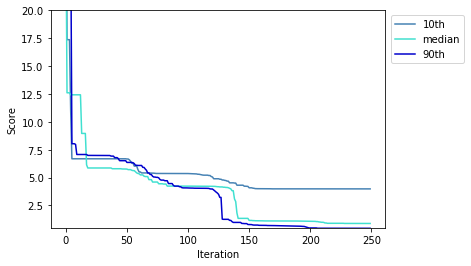

Starting CMA-NOT for 25 tries with 250 iterations each
Done in 275.14097809791565 seconds
Failed 0 times
Ratio of points within distance d (d = distance between best_x and real_params) from the best x: 1.0
10th Percent.   |   median    |    90th Percent. for  CMA-NOT
0.88747  	  0.88747  	  0.45658


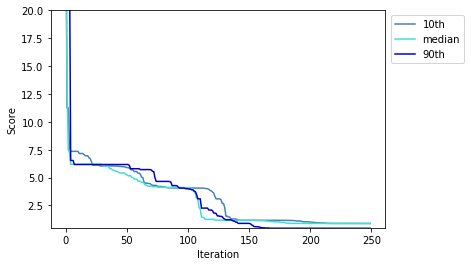

Starting IGO-CMA for 25 tries with 250 iterations each
Done in 891.1235272884369 seconds
Failed 0 times
Ratio of points within distance d (d = distance between best_x and real_params) from the best x: 1.0
10th Percent.   |   median    |    90th Percent. for  IGO-CMA
5.55989  	  5.23172  	  4.82012


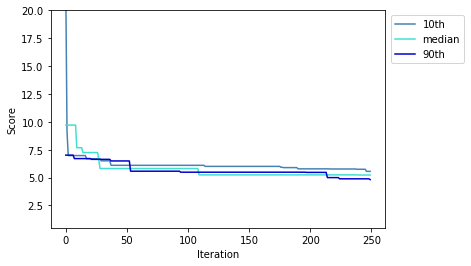

Starting IGO_ETA for 25 tries with 250 iterations each
Done in 805.0600368976593 seconds
Failed 0 times
Ratio of points within distance d (d = distance between best_x and real_params) from the best x: 1.0
10th Percent.   |   median    |    90th Percent. for  IGO_ETA
6.62751  	  5.93638  	  5.55981


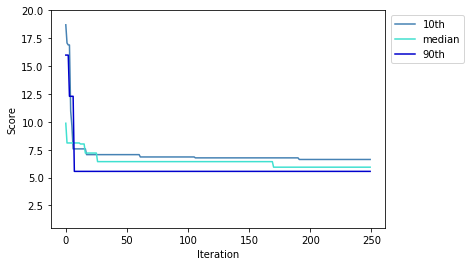

Starting IGO_WEIGHT for 25 tries with 250 iterations each
Done in 858.113094329834 seconds
Failed 0 times
Ratio of points within distance d (d = distance between best_x and real_params) from the best x: 0.96
10th Percent.   |   median    |    90th Percent. for  IGO_WEIGHT
5.48370  	  4.47259  	  3.95433


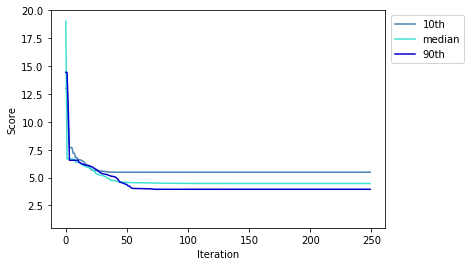

Starting IGO_FAKE for 25 tries with 250 iterations each


/home/naunauyoh/Desktop/PINTS/Test_Bed/igocma.py:985: RuntimeWarning: invalid value encountered in sqrt
  self._D = np.sqrt(np.diag(eigenvals))


One run failed:  Eigenvalues did not converge

One run failed:  Eigenvalues did not converge

Done in 736.505348443985 seconds
Failed 2 times
Ratio of points within distance d (d = distance between best_x and real_params) from the best x: 0.9565217391304348
10th Percent.   |   median    |    90th Percent. for  IGO_FAKE
2.88018  	  1.07697  	  0.88747


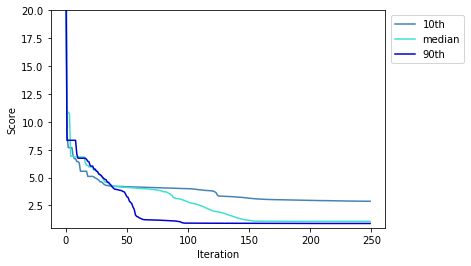

Starting SNES for 25 tries with 250 iterations each
Done in 344.88666105270386 seconds
Failed 0 times
Ratio of points within distance d (d = distance between best_x and real_params) from the best x: 1.0
10th Percent.   |   median    |    90th Percent. for  SNES
3.99397  	  3.98968  	  0.62853


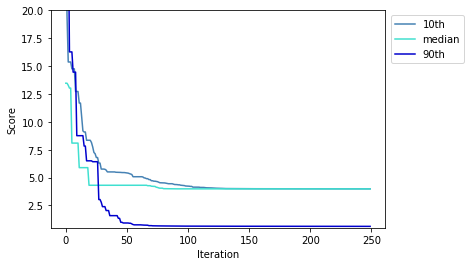

Starting XNES for 25 tries with 250 iterations each
Done in 385.7649013996124 seconds
Failed 0 times
Ratio of points within distance d (d = distance between best_x and real_params) from the best x: 0.96
10th Percent.   |   median    |    90th Percent. for  XNES
3.99009  	  3.22085  	  0.60543


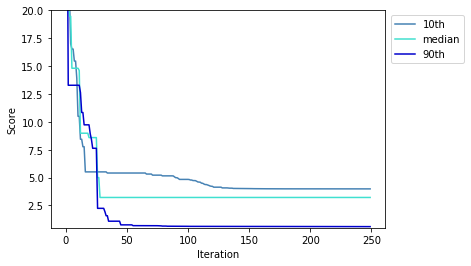

All scores
TENTH PERC
score 1.5829790586355292
normalized_score 3.9896820170940708

score 0.3521182442865523
normalized_score 0.8874658318801235

score 2.180281136559042
normalized_score 5.49510013748188

score 2.6198192927247574
normalized_score 6.6028958899996635

score 2.0247699591338746
normalized_score 5.103155503315263

score 1.5809566166348152
normalized_score 3.9845847288912695

score 1.583567048598372
normalized_score 3.9911639653031696

score 1.5830951922207903
normalized_score 3.9899747158977408



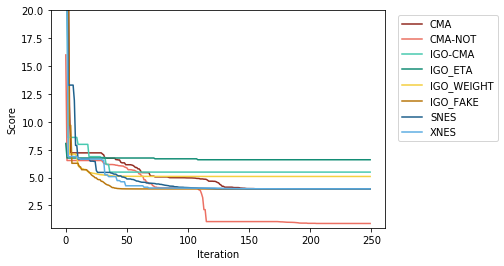

MEDIAN
score 0.35213281806116054
normalized_score 0.8875025630839626

score 0.3521181930101058
normalized_score 0.8874657026448595

score 2.070409892649163
normalized_score 5.218184707911482

score 2.3521980444515345
normalized_score 5.928393169446756

score 1.7368501137798762
normalized_score 4.377492947574635

score 0.42730704927450724
normalized_score 1.076968921962571

score 1.322668295982864
normalized_score 3.3336043747867996

score 0.7682822898369452
normalized_score 1.9363503383654417



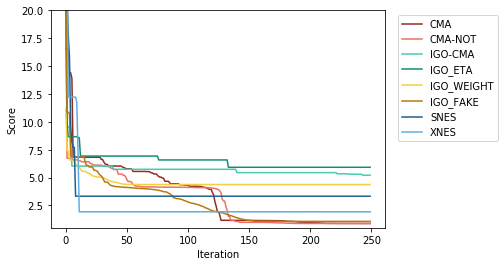

NINETENTH PERC
score 0.18115684053376727
normalized_score 0.4565810172966792

score 0.18115654798669384
normalized_score 0.45658027997182854

score 1.9124706165145504
normalized_score 4.820120383339642

score 2.2059559887195985
normalized_score 5.559810087621596

score 1.5689534477203668
normalized_score 3.9543323848031577

score 0.3521182117412308
normalized_score 0.887465749854096

score 0.2493794994391522
normalized_score 0.6285268898010016

score 0.2402142875355397
normalized_score 0.6054272278596629



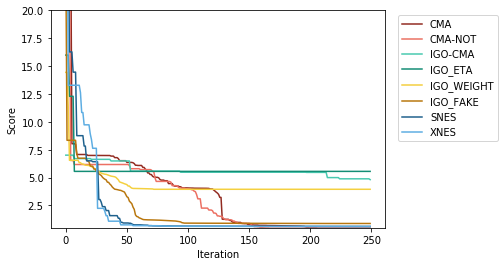

Done with HES Michaelis-Menten
############################################


In [13]:
for key, value in model_dict.items():
    
    print("Currently testing on", key)
    
    x0 = value['x0']

    xnes = pints.XNES(x0)
    snes = pints.SNES(x0)
    cma_not = pints.CMAES(x0)
    my_cma = cma_arnaud.CMAES(x0)
    
    pop = 25
    q_0 = 0.25
    eta = 0.8
    
    igocmareal = igocma.IGOCMA(x0)
    igocmareal.set_pop_and_n_q0(pop,q_0)
    igocmareal.set_lr(eta)
    
    igocmaeta = igocma.IGOCMA_diff_eta(x0)
    igocmaeta.set_pop_and_n_q0(pop,q_0)
    
    igocmaweight = igocma.IGOCMA_diff_weights(x0)
    igocmaweight.set_pop(pop)
    igocmaweight.set_lr(eta)
    
    igocmafake = igocma.IGOCMAFake(x0)
    igocmafake.set_pop(pop)
    
    
    #opts = [ ("CMA", cma, "b"),("CMA-NOT",cma_not, "g"),  ("SNES", snes, "c"), ("XNES", xnes, "r")]
    opts = [ ("CMA", my_cma, "#922b21"), ("CMA-NOT",cma_not, "#ec7063"), 
            ("IGO-CMA", igocmareal, "#48c9b0"), ("IGO_ETA", igocmaeta, "#138d75"),
            ("IGO_WEIGHT", igocmaweight, "#f4d03f"), ("IGO_FAKE", igocmafake, "#b9770e"), 
            ("SNES", snes, "#1f618d"), ("XNES", xnes, "#5dade2")]
    
    out_name = key + "_results.pickle"
    pickle_out =  open(out_name,"wb")
    
    if 'score' in value:
        all_result_info = model_testbed(value['model'], value['real_parameters'], 
                                        value['times'], opts, 
                                        score=value['score'], timed=True, 
                                        is_prob_model=True, maximization=True, problem_name="IGO_" + value['name'])
    else:
        all_result_info = model_testbed(value['model'], value['real_parameters'], value['times'], opts, 
                                        timed=True, limit=value['normalized_graph_limit'], problem_name="IGO_" + value['name'])
    
    pickle.dump(all_result_info, pickle_out)
    pickle_out.close()

    print("Done with", key)
    print('############################################')

In [ ]:
for key, value in model_dict.items():
    
    if not 'score' in value:
        model = value['model']
        real_parameters = value['real_parameters'] 
        times = value['times']
        #Generate the values
        try:
            values, _ = model.simulateS1(real_parameters, times)
        except:
            values = model.simulate(real_parameters, times)

        # Add noise
        values += np.random.normal(0, 10, values.shape)
        # Create an object with links to the model and time series
        try:
            my_problem = pints.SingleOutputProblem(model, times, values)
        except:
            my_problem = pints.MultiOutputProblem(model, times, values)
        # Select a score function
        score = pints.MeanSquaredError(my_problem)
        optimum_score = score(value['real_parameters'])

    else:
        score = value['model']
        optimum_score = np.exp(score(value['real_parameters']))

    name = value['name']
    print(name)
    pickle_in = open(key + "_results.pickle","rb")
    all_result_info = pickle.load(pickle_in)
    save_all_percentile_graphs(all_result_info, value['normalized_graph_limit'], "IGO_" + name, score_normalizer=optimum_score)

In [ ]:
# GoodwinOscillatorModel #
GOM_dict = dict()

GOM_dict['name'] = "Goodwin Oscillator Model"
GOM_dict['model'] = toy.GoodwinOscillatorModel()

GOM_dict['real_parameters'] = GOM_dict['model'].suggested_parameters() #[2, 4, 0.12, 0.08, 0.1]
GOM_dict['times'] = GOM_dict['model'].suggested_times()

GOM_dict['boundaries'] = pints.RectangularBoundaries([-20, -200, -2, -2, -2], [20, 200, 2, 2, 2])

GOM_dict['x0'] = [10, 15, 0.7, 0.40, 0.9]
GOM_dict['graph_limit'] = [50,200]
H1_dict['normalized_graph_limit'] = [0,20]


model_dict['Three-state Goodwin oscillator'] = GOM_dict
